# Model Description

## Parameters

Each paramter is matched to its code equivalent as follow. Parameters are declared either as a range or enum type, and can be imported into MiniZinc using dzn files. Qualities of these parameters/enum types are declared as arrays. Range in the following code starts from 1. Note that the CP model ignores PE $\rightarrow$ router links by taking routers as NoC nodes. Adjustments are made to starting and ending times to acommodate this setting.

<dl>
    <dt>Time is declared with a max (range) b:</dt> 
        <dd>$\mathcal{T} = \{t_1, \dots, t_b\}$</dd>
        <code>int: max_time = b;</code> 
</dl>
<dl>
    <dt>Dataflow actors as enum type:</dt>
        <dd>$\mathcal{A} = \{a_1, \dots, a_m\}$</dd>
        <code>enum actors = {a1, a2, ..., am};</code>
</dl>
<dl>
    <dt>Execution time of actors:</dt>
        <dd>$\mathcal{E} = \{e_1, \dots. e_n\}$</dd>
        <code>array[actors] of int: execution_time = [0,0,0];</code>
</dl>
<dl>
    <dt>NoC size is declared with a max int such that $n*n=m$</dt>
        <dd>$\mathcal{V} = \{v_1, \dots, v_m\}$</dd>
        <code>int: noc = n;</code>
</dl>
<dl>
    <dt>Messages list declared with enum type</dt>
        <dd>$\mathcal{M} = \{m_1, \dots. m_n\}$</dd>
        <code>enum messages = {m1, m2, ..., mn};</code>
</dl>
<dl>
    <dt>TDM max slot and TDM table for router to router as 2d (flattened) array</dt>
    <dd>$\mathcal{NOC_X} = \{1, \dots, x\}$</dd>
    <dd>$\mathcal{NOC_Y} = \{1, \dots, y\}$</dd>
    <dd>$TDM^{max} \in \mathbb{Z}$</dd>
    <dd>$TDM_{(x \in \mathcal{NOC_X}, y \mathcal{NOC_Y})} \in \mathbb{Z}$</dd>
    <dd>Each element in the tdma table represents the tdma slot for source to destimation node, and can be called with tdma_table[actor1, actor2]</dd>
    <code>int: tdma_max = 2;</code>
    <code>array[1..noc*noc, 1..noc*noc] of int: tdma_table = array2d(1..noc, 1..noc, [1, ..., 1,
                                                                                          ...,    
                                                                                      1, ..., 1]);</code>

<dl>
    <dt>Source and destination of messages</dt>
        <dd>$src_M(m_i) = a_s \in \mathcal{A}$</dd>
        <dd>$dest_M(m_i) = a_d \in \mathcal{A}$</dd>
        <code>array[messages] of int: src = [1,2,3,3,3]; 
array[messages] of int: dst = [2,3,1,1,1]; 
function actors: source(messages: m) = actors[src[m]];
function actors: dest(messages: m) = actors[dst[m]];</code>
</dl>
<dl>
    <dt>Message dependencies</dt>
    <dd>Elements of the array are the indexes in the message list where 0 means Null (can start whenever)</dd>
        <code>array[messages] of int: dependencies = [0,1,2,3,4];</code>
</dl>

## Variables and Functions

Variables are defined as arrays in relationship to the above enum types. We may use the constraint condition in code to define these relationships.
<dl>
    <dt>Message Mapping</dt>
        <dd>$map_x(a) = x_1 + 2x_2 + \dots +|NoC_x|\times x_{|NoC_x|} \quad | \quad \sum_i x_{ai} = 1$</dd>
        <dd>$map_y(a) = y_1 + 2y_2 + \dots +|NoC_y|\times y_{|NoC_y|} \quad | \quad \sum_i x_{ai} = 1$</dd>
    <dd>The mapppings in code are identified uniquely by their index in the 2d array</dd>
        <code>array[actors] of var 1..noc: mapx;
array[actors] of var 1..noc: mapy;
function var int: mapping(var int: x, var int: y) = (y-1)*noc + x;</code>
</dl>
<dl>
    <dt>Message Routing</dt>
    <dd>$\begin{align}route_d(m) &= \{d_1^m, \dots, d_b^m\} \text{ where }
        d_i^m = 
            \begin{cases}
                1 \text{ if movement in direction $d$ at time $i$}\\
                0 \text{ else } 
            \end{cases}
            \label{eqr}
    \end{align}$</dd>
    <code>array[messages, 1..max_time] of var 0..1: route_n;
array[messages, 1..max_time] of var 0..1: route_s;
array[messages, 1..max_time] of var 0..1: route_e;
array[messages, 1..max_time] of var 0..1: route_w;</code>
</dl>
<dl>
    <dt>Message Start and End Time (Route length)</dt>
    <dd>$fire(m) = t \in \mathcal{T} \quad | \quad \sum_{i=1}^{i=t+1} \sum_d d^m_i = 1$</dd>
    <dd>$|route(m)| = \sum_{t=t1}^{t=b} \sum_{d=\{N,S,E,W\}} d_t^m\label{eql}$</dd>
</dl>

`array[messages] of var 1..max_time: starts;
array[messages] of var 1..max_time: ends;
constraint forall (m in messages)(
  starts[m] = min(t in 1..max_time where route_n[m,t]+route_s[m,t]+route_e[m,t]+route_w[m,t] > 0)(t)
);
constraint forall (m in messages)(
  ends[m] = max(t in 1..max_time where route_n[m,t]+route_s[m,t]+route_e[m,t]+route_w[m,t] > 0)(t)
);`

<dl>
    <dt>Schedule Makespan</dt>
    <dd>$S_{max}$</dd>
    <code>var 1..max_time: makespan;</code>
</dl>

## Objective

$\min S_{max}$

<code>solve minimize makespan;</code>

## Constraints

1. The first constraint guarantees that a message sent from its source actor will reach its destination.
$$
\begin{align}
    &\forall m \in \mathcal{M}:\\
    &\sum_{t=1}^{t=b} e^m_t - w^m_t = map_x(dest_M(m)) - map_x(src_M(m)) \\
    &\sum_{t=1}^{t=b} s^m_t - n^m_t = map_y(dest_M(m)) - map_y(src_M(m))
\end{align}
$$

`constraint forall(m in messages)(
  sum([route_s[m,t] - route_n[m,t] | t in 1..max_time]) = mapy[dest(m)] - mapy[source(m)]
);
constraint forall(m in messages)(
  sum([route_e[m,t] - route_w[m,t] | t in 1..max_time]) = mapx[dest(m)] - mapx[source(m)]
);`

2. The second constraint guarantees the validity of the route variable where messages move one unit axis at a time and the route does not go off the NoC grid.
$$
\begin{align}
    \sum_d d_t^m &\leq 1 \quad \forall t \in \mathcal{T}, m \in \mathcal{M}\label{c2}\\
    \sum_{t=t1}^{t=i} d0^m_t - d1^m_t &< |NoC_d| \quad \forall i \leq b, (d0,d1) \in \{(N,S), (E,W)\}\label{c3}
\end{align}
$$

`constraint forall (m in messages)(
  forall (t in 1..max_time)(
    route_n[m,t]+route_s[m,t]+route_e[m,t]+route_w[m,t] <= 1
  )
);
constraint forall(m in messages)(
  forall(curr_t in 1..max_time)(
    sum([route_s[m,t] - route_n[m,t] | t in 1..curr_t]) + mapy[source(m)] > 0 /\ sum([route_s[m,t] - route_n[m,t] | t in 1..curr_t]) + mapy[source(m)] <= noc
  )
);
constraint forall(m in messages)(
  forall(curr_t in 1..max_time)(
    sum([route_e[m,t] - route_w[m,t] | t in 1..curr_t]) + mapx[source(m)] > 0 /\ sum([route_e[m,t] - route_w[m,t] | t in 1..curr_t]) + mapx[source(m)] <= noc 
  )
);
`
    

3. The third constraint is relevant for bufferless NoC routing where messages can not be stored mid-traffic before being received by destination PEs. The following restriction prevents cases where a column of zeroes exist between columns of non-zeroes. In code, this is done with a triple for loop.
$$
\begin{align}
    \sum_d d_{t=i}^m - \sum_d d_{t=i+j}^m + \sum_d d_{t=i+k}^m \leq 1 \quad &\forall i \leq b, i+k \leq b, 0 < j < k,\\
    & \forall m \in \mathcal{M}
\end{align}
$$

`constraint forall (m in messages)(
  forall (t in 1..max_time)(
    forall(t1 in 1..max_time where t1 > t)(
      forall(t2 in 1..max_time where t2 > t1)(
        route_n[m,t]+route_s[m,t]+route_e[m,t]+route_w[m,t] - route_n[m,t1]+route_s[m,t1]+route_e[m,t1]+route_w[m,t1] + route_n[m,t2]+route_s[m,t2]+route_e[m,t2]+route_w[m,t2] <= 1
      )
    )
  )
);`
    

4. The fourth constraint defines that an actor cannot have multiple messages sent at the same time.
    $$
\begin{align}
    \sum_m \sum^{t=i}_{t=1} \sum_d d^m_t \leq 1 \quad \forall t \in \mathcal{T}, \forall a \in \mathcal{A} \text{ such that }m \in src_M(a) 
\end{align}
$$

`constraint forall (a in actors)(
  alldifferent([starts[m] | m in messages where source(m) = a])
);`
    

5. The fifth constraint defines $S_{max}$ to be larger than the sum of any message starting time, with the corresponding message $m$'s route length, execution time, and tdm delay. For static routing algorithms, the route length is the Manhattan distance between the source and destination actor. For dynamic routing, we make use of the $route_x, route_y$ values as described in constraint 6.
    $$
\begin{align}
    S_{max} \geq t + |route(m)| \quad  \forall t \in \mathcal{T}, fire(m) = t
\end{align}
$$

`constraint forall (m in messages)(
  makespan >= ends[m]
);`
    

6. The sixth constraint defines each subsequent message sent from $a$ to start later than the any of the sum of start time of messages delivered to $a$, route length, execution time, and tdma restrictions. This is replaced in code by the condition of having messages that depend on other messages be sent only after their end times
\begin{align}
    t_j \geq t_i + |route(m_i)| + e_i \quad  &\forall t_i,t_j \in \mathcal{T} \quad |\quad i < j,\\ &src_M(m_j) = dest_M(m_i), fire(m_i) = t_i, fire(m_j) = t_j
\end{align}

`constraint forall (m in messages)(
  starts[m] > if dependencies[m] > 0 then ends[messages[dependencies[m]]]+consume_time else 1 endif 
);`
    

7. The seventh constraint defines the firing times for messages sent from a certain mapped actor to adhere to a chosen tdma rule for that PE node. Since the firing time $fire(m)$ denotes the time when message $m$ reaches the nearest router node (assumed one travelled edge for every PE in the NoC graph), we subtract one clock time.
    $$
\begin{align}
    fire(m) -1 = tdm^{max} \times d_m + tdm_{(map_x(src_M(m)), map_y(src_M(m)))} \quad \forall m \in \mathcal{M}
\end{align}
     $$

`constraint forall (m in messages)(
  (starts[m]-1) mod tdma_max = tdma_table[mapping(mapx[source(m)],mapy[source(m)]), mapping(mapx[dest(m)],mapy[dest(m)])]
);
`
    

8. The eighth constraint guarantees that no two messages may be travelling across the same channel in the NoC at the same time, where either equations must be true. The same code is used for each of the four directions. Less than 2 means only one may be 1. Less than 3 means any value.
$$\begin{align}
    &\sum^{t} x_{t}^{m_i} + map_x(src_M(m_i)) = \sum^{t} x_{t}^{m_j} + map_x(src_M(m_j)) \label{eq1} \\
    &\text{ and}\\
    &\sum^{t} y_{t}^{m_i} + map_y(src_M(m_i))= \sum^t y_{t}^{m_j} + map_y(src_M(m_j)) \label{eq2}
\end{align}
$$

`constraint forall (t in 1..max_time-1)(
  forall (m_prev in messages)(
    forall (m_next in messages where m_next > m_prev)(
      route_n[m_prev, t+1]+route_n[m_next, t+1] < if
      mapping(mapx[source(m_prev)] + route_e[m_prev,t] - route_w[m_prev,t], mapy[source(m_prev)] + route_s[m_prev,t] - route_n[m_prev,t]) = mapping(mapx[source(m_next)] + route_e[m_next,t] - route_w[m_next,t], mapy[source(m_next)] + route_s[m_next,t] - route_n[m_next,t])
      then 2
      else 3
      endif
    )
  )
);`

9. The ninth constraint defines one and only one start time for each message. This does not need to be implemented in code since this applies by design.
$$
\begin{align}
    \sum_{t\in\mathcal{T}} f_m^t = 1 \quad \forall m \in \mathcal{M}, fire(m)=t
\end{align}
$$

10. The tenth constraint ensures that each actor takes up a unique position in the NoC. 
$$
\begin{align}
    \sum_a x_{ai} = |NoC_y| \quad \forall x_i \in NoC_x, a \in \mathcal{A}\\
    \sum_a y_{ai} = |NoC_x| \quad \forall y_i \in NoC_y, a \in \mathcal{A}
\end{align}
$$
     <code>constraint alldifferent([mapping(mapx[a],mapy[a]) | a in actors]);</code>

# Model Output

Model can be run by clicking on the app's run button, or on compile line (with additional data files [.dzn] as subsequent arguments) to generate values for the defined variables. Note that MiniZinc deal with multi-dimension arrays as flattened arrays so we need to manually divide the route list for each message. The first result applied TDMA, the second does not (hence odd value start times).

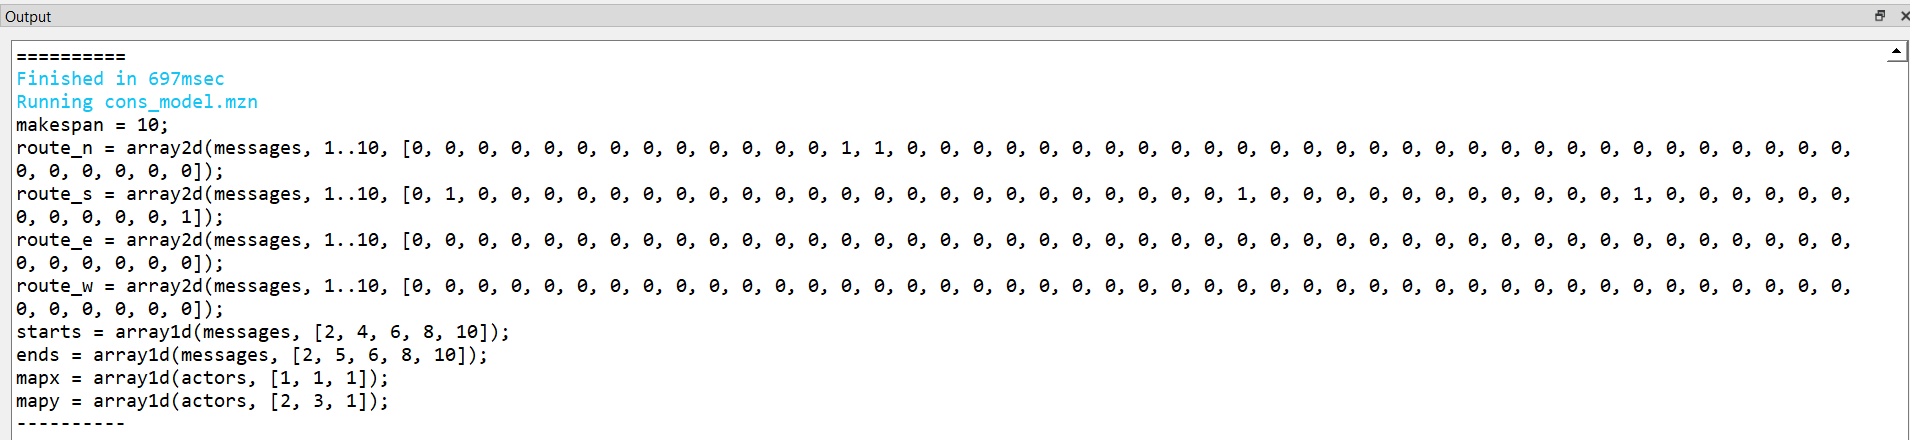

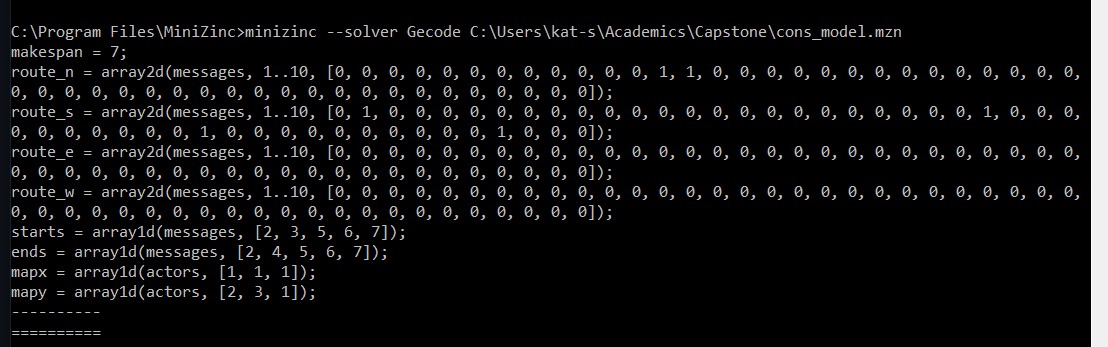